#### CartPole
##### with Q-learning from scratch

In [16]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation
import threading
import pickle
import joblib
import copy
import threading
from sklearn import impute, preprocessing, model_selection, base, metrics, linear_model, pipeline, ensemble, svm, multiclass, neighbors, compose, datasets, decomposition, manifold
import tensorflow as tf
from tensorflow import keras
import cv2
from scratch_models import my_decorators
import gym
import pygame as pg

#### Environment
**Setup the CartPole environment**

In [17]:
# Environment
env = gym.make('CartPole-v1', render_mode='rgb_array')
clock = pg.time.Clock()

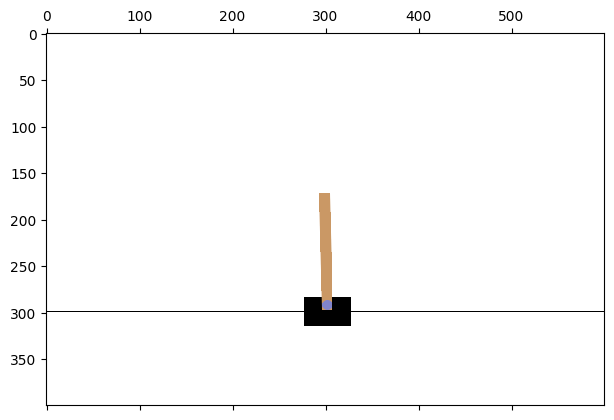

In [18]:
test_obs, _ = env.reset()
test_obs

frame = env.render()
frame = np.rot90(frame, 2)
frame = np.flipud(frame)
plt.matshow(frame)

In [19]:
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [20]:
env.action_space

Discrete(2)

Set up initial parameters for Q-learning:

**$\alpha$ = 0.075** is the learning rate;
**$\epsilon$ = 1.0** is the initial value that will be used in Exploration-Exploitation trade-off for $\epsilon$-greedy algorithm;
**$\gamma$ = 0.95** is the discount factor, the higher the $\gamma$, the more the weightage of future states on the returns
**$\epsilon$-decay** = 0.995

**Q-table** : Initially a 25x25x25x25x2 tensor with zeroes, because we will be testing 25 different values for each of the 4 states against 2 possible actions.

In [21]:
# Set initial parameters
params = {'alpha':0.075, 'gamma':0.95, 'epsilon':1.0}

# Initialize Q-table
n_actions = env.action_space.n
state_bins = [np.linspace(-x, x, num=24) for x in env.observation_space.high]
Q_table = np.zeros([len(bin) + 1 for bin in state_bins] + [n_actions])

**Define a Policy**
I am going to explore three different policies:
   * User Controlled (``rl=no-policy``) : User plays the game with keyboard inputs
    * Harcoded policy (``rl='basic'``) : A simple rule based policy that moves the cart to right if the pole tilts right and moves the cart left if the pole tilts left, in order to balance the pole.
   * Q-learning based policy (``rl='q-learning'``) : Applies **Q-learning** to learn by interacting with the environment on it's own.

In [53]:
def policy(obs, rl='no-policy'):
    action = None
    
    if rl == 'no-policy':
        return action

    if rl=='basic':
        angle = obs[2]
        action = 1 if angle>0 else 0
        return action
    
    if rl=='q-learning':            
        # Choose action as per epsilon-greedy method
        if np.random.rand()<params['epsilon']:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_table[obs])
        
        # epsilon-decay
        if params['epsilon']>0.1:
            params['epsilon']*=0.995
        return action   

**Update the Q-table**
This step is the essence of Q-learning, the Q-table initialized above gets updated based next state, action and reward as per the following expression:

$$
Q(s, a) \leftarrow (1 - \alpha) \cdot Q(s, a) + \alpha \cdot (r + \gamma \cdot \max_{a'} Q(s', a'))
$$


In [23]:
# Update Q-table
def update_Q(obs, action, reward):
    best_next_action = np.argmax(Q_table[obs])
    Q_table[obs][action] = (1 - params['alpha']) * Q_table[obs][action] + params['alpha'] * (reward + params['gamma'] * Q_table[obs][best_next_action])

The following function is simply to discretize the state space returned by CartPole so that it's compatible with the Q-table.

In [24]:
# Will be used to discretize the state space as CartPole returns a continuous space 
def discretize(state):
    state_indices = []
    for i in range(len(state)):
        lower_bound = state_bins[i][0] if isinstance(state_bins[i][0], (int, float)) else state_bins[i][0][0]
        upper_bound = state_bins[i][-1] if isinstance(state_bins[i][-1], (int, float)) else state_bins[i][-1][-1]

        if state[i] <= lower_bound:
            state_index = 0
        elif state[i] >= upper_bound:
            state_index = len(state_bins[i]) - 1
        else:
            state_index = np.digitize(state[i], state_bins[i]) - 1
        state_indices.append(state_index)


    return tuple(state_indices)

**Draw the Game Screen**

In [25]:
# Run animations
def animate(env, win, clock, episode_rewards, env_rewards, policy_type):
    clock.tick(15)
    run = True
    frame = env.render()
    frame = np.rot90(frame)
    frame = np.flipud(frame)
    
    font = pg.font.Font(None, 36)
    text_surface_current = font.render('Current Score: '+ str(episode_rewards), True, (100,0,0))
    text_surface_high = font.render('Highest Score: '+str(max(env_rewards[policy_type])), True, (0,100,100))
    surface = pg.surfarray.make_surface(frame)
    
    win.blit(surface, (0, 0))
    win.blit(text_surface_current, (0, 0))
    win.blit(text_surface_high, (0, 40))
    pg.display.update()

    for event in pg.event.get():
        if event.type == pg.QUIT:
            run = False
            pg.quit()
    return run
            
# User controlled settings if no policy     
def run_by_user(animation):
    action = None
    if animation:
        user_input = pg.key.get_pressed()
        if user_input[pg.K_RIGHT]:
            action = 1
        elif user_input[pg.K_LEFT]:
            action = 0
        return action
    else:
        raise ValueError('Animation must be True in user-controlled policy')

**Simulate**
Next, I shall create some functions to simulate the CartPole environment based on different policies. The first two policies are self-explanatory, while the Q-learning policy simply starts by taking an action based on the $\epsilon$-greedy algorigthm, and then updates the Q-values until it reaches satisfactory score or is halted.

In [51]:
env_rewards = {'no-policy':[0], 'basic':[0], 'q-learning':[0]}

# Main function to run the simulation
def simulate_episode(env, policy_type='no-policy', animation=True):
    obs, info = env.reset()                                                 #  0 Get initial state of the env
    obs = discretize(obs)
    clock = pg.time.Clock()
    
    # Initialize Pygame if animation is True
    if animation:
        clock.tick(15)
        win = pg.display.set_mode((600, 400))
        pg.init()
        run = True
    else:
        run = 500


    episode_rewards = 0                                                         #1  Initialize rewards
    while run:        
        action=policy(obs, policy_type)                                         #2  Choose an action based on policy
        
        if action is None:                                                      #  If user-controlled
            action = run_by_user(animation)
                
        if action is not None:
            obs, reward, done, truncated, info = env.step(action)               #3  Take the decided action to reach next state
            
            episode_rewards += reward                                           #5  Update rewards
            if policy_type=='q-learning':
                obs = discretize(obs)
                update_Q(obs, action, reward)                                   #6  Update Q-values
                
            if done:                                                
                obs, info = env.reset()
                break
        
        if animation:
            run = animate(env, win, clock, episode_rewards, env_rewards, policy_type)
        else:
            run-=1
    
    env_rewards[policy_type].append(episode_rewards)
    env.close()

In [56]:
simulate_episode(env, policy_type='no-policy', animation=True)

**1. User Controlled**

In [33]:
# Reset the scores (Rewards)
env_rewards = {'no-policy':[0], 'basic':[0], 'q-learning':[0]}

In [57]:
simulate_episode(env, policy_type='no-policy', animation=True)
max(env_rewards['no-policy'])

27.0

**2. Basic Hardcoded Policy**

In [58]:
for episode in range(2):    
    simulate_episode(env, policy_type='basic', animation=True)
max(env_rewards['basic'])

64.0

**3. Q-Learning**

In [59]:
for episode in range(10):
    simulate_episode(env, policy_type='q-learning', animation=True)
max(env_rewards['q-learning'])

60.0

**Kartik Kumar**
For more such projects, visit [My GitHub Page](https://github.com/ryuukkk?tab=repositories)